In [ ]:
# 최적화 계산, 수학적 계산, 시각화, 공간 데이터 처리, 좌표계 변환
!pip install pulp pyproj

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import pulp
import matplotlib.pyplot as plt
from pyproj import Transformer

In [3]:
# 시각화를 위해 좌표 -> UTM_K 좌표계 변환 생성
trans = Transformer.from_crs("epsg:4326", "epsg:5179", always_xy=True)

# 데이터 불러오기 함수 (좌표 값(x,y))

# 수요지 데이터
def dataLoad(route):
    df = pd.read_csv(route)
    x, y = trans.transform(df['_X'].values, df['_Y'].values) # 좌표변환
    return np.column_stack([x, y]), df['val'].values

# 기존 키즈카페, 후보지 데이터
def coordLoad(route):
    df = pd.read_csv(route)
    x, y = trans.transform(df['_X'].values, df['_Y'].values) # 좌표변환
    return np.column_stack([x, y])

# CSV파일로부터 데이터 불러오기
demandCoord, demandWeight = dataLoad('demand_data.csv')
candidateCoord = coordLoad('candidate_data.csv')
existingCoords = coordLoad('kidscafes.csv')

In [4]:
# MCLP 함수 (Pulp 최적화 라이브러리 사용)

def mclp(demandCoord, demandWeight, candidateCoord, numFacilities, serviceRadius, existingCoords=None, minDistance=0):
    
    # 기존 시설 커버 수요지 저장용 배열
    existing_cover = [False] * len(demandCoord)

    # 기존 시설이 있으면 거리 계산 후 커버 여부 판단
    if existingCoords is not None and len(existingCoords) > 0:
        dist_ex = distance_matrix(demandCoord, existingCoords) # 수요지 - 기존 시설 거리 
        existing_cover = (dist_ex <= serviceRadius).any(axis=1) # 하나라도 반경 안에 있으면 1
    
    # 필터링에 사용할 배열
    yes_candidate = candidateCoord[:]
    
    # 기존 시설과의 최소거리 판단 (후보지 필터링)
    if existingCoords is not None and minDistance > 0:
        dist_to_ex = distance_matrix(candidateCoord, existingCoords) # 후보지 - 기존 시설 거리
        yes_mask = np.all(dist_to_ex >= minDistance, axis=1) # 기존 시설이랑 너무 가깝지 않은
        yes_candidate = candidateCoord[yes_mask] # 필터링 결과 저장
    
    # 문제 객체 생성
    MCLP = pulp.LpProblem("MCLP", pulp.LpMaximize)

    # 수요지 - 후보지 거리 행렬 및 커버 여부 행렬 생성
    dist_matrix = distance_matrix(demandCoord, yes_candidate)
    coverage = (dist_matrix <= serviceRadius).astype(int)

    # 후보지 선택 여부 변수 
    x = pulp.LpVariable.dicts("x", range(len(yes_candidate)), cat='Binary')

    # 수요지 커버 여부 변수 
    y = pulp.LpVariable.dicts("y", range(len(demandCoord)), cat='Binary')

    # 목적함수 : 기존 시설로 커버못한 수요지(유아인구)를 새로운 시설을 선정함으로써 커버되는 수요지(유아인구)의 최대화
    MCLP += pulp.lpSum(y[i] * demandWeight[i] * (1 - existing_cover[i]) for i in range(len(demandCoord)))
    
    # 제약조건 1 : 설치 가능한 시설 수는 numFacilites 만큼
    MCLP += pulp.lpSum(x) == numFacilities
   
    # 제약조건 2 : 각 수요지는 최소 하나 이상의 후보지로부터 커버되어야 함
    for i in range(len(demandCoord)):
        MCLP += y[i] <= pulp.lpSum(x[j] * coverage[i, j] for j in range(len(yes_candidate)))
    
    # solver (문제 풀이)
    MCLP.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # 선택된 후보지 인덱스 추출
    select = [j for j in range(len(yes_candidate)) if x[j].varValue == 1]

    # 좌표로 변환
    selectedSites = yes_candidate[select]

    new_cover = [False] * len(demandCoord)

    # 선택된 후보지가 수요지를 얼마나 커버하는지
    if len(selectedSites) > 0:
        dist_new = distance_matrix(demandCoord, selectedSites) # 수요지 - 신규시설 거리 행렬
        new_cover = (dist_new <= serviceRadius).any(axis=1)
    
    # 전체 커버 여부 계산 (기존 + 신규)
    total_cover = existing_cover | new_cover

    # 유아 인구 합 계싼
    totalPossible = np.sum(demandWeight)

    # 기존 시설 커버 유아 인구
    existingWeight = np.sum(demandWeight[existing_cover])
    
    # 신규 커버 유아 인구
    newWeight = np.sum(demandWeight[new_cover & ~existing_cover])
    
    # 총 커버 인구
    totalWeight = existingWeight + newWeight

    # 선정 입지 좌표, 커버율 반환
    return selectedSites, existingWeight, newWeight, totalWeight, totalPossible


In [5]:
# 시각화 함수 1 (기존시설 + 신규시설 커버 분석용)
def visual1(demandCoord, demandWeight, candidateCoord, existingCoord, selectedSites, serviceRadius, existingWeight, newWeight, totalWeight, totalPossible):
    
    plt.figure(figsize=(10, 8))
    
    # 후보지 마커 표시
    plt.scatter(candidateCoord[:,0], candidateCoord[:,1], c='skyblue', alpha= 0.4, edgecolors='blue', marker='o', label=f'후보지 ({len(candidateCoord)}개)')
    
     # 수요지 마커 표시
    plt.scatter(demandCoord[:,0], demandCoord[:,1], c=demandWeight, cmap='YlOrRd', alpha=0.6, s=50, edgecolors='orange', label=f'수요지 ({len(demandCoord)}개)')
    gradient_bar = plt.colorbar(label='유아 인구 수')
    gradient_bar.set_label('유아 인구 수', rotation=270)
    
    
    # 신규 선정 시설 표시
    plt.scatter(selectedSites[:,0], selectedSites[:,1], c='purple', s=200, edgecolor='black', label=f'선정 시설 ({len(selectedSites)}개)')
    for site in selectedSites:
        plt.gca().add_patch(plt.Circle(site, serviceRadius, color='purple', fill=False, linestyle='--'))
    
    # 기존 시설 마커 표시
    if existingCoords is not None:
        plt.scatter(existingCoord[:,0], existingCoord[:,1], c='lightgreen', s=150, edgecolors='green',marker='s', label=f'기존 시설 ({len(existingCoord)}개)')
        for site in existingCoord:
            plt.gca().add_patch(plt.Circle(site, serviceRadius, color='green', fill=False, linestyle='--'))
    

# legend 추가
    plt.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(0, 1))
    
    # plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f'서울형 키즈카페 입지 분석')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    
    plt.show()

In [6]:
# 시각화 함수 2 (신규 선정 시설 위치 확인용)
def visual2(demandCoord, demandWeight, candidateCoord, existingCoords, selectedSites, serviceRadius, existingWeight, newWeight, totalWeight, totalPossible):
    
    plt.figure(figsize=(9, 7))
    
    # 수요지 마커 표시
    scatter1 = plt.scatter(demandCoord[:,0], demandCoord[:,1], c=demandWeight, cmap='Reds', alpha=0.8, s=40, edgecolors='darkred', linewidth=0.3, label=f'수요지 ({len(demandCoord)}개)')
    gradient_bar = plt.colorbar(scatter1)
    gradient_bar.set_label('유아 인구 수', rotation=270)
    
    # 후보지 마커 표시
    plt.scatter(candidateCoord[:,0], candidateCoord[:,1], c='dodgerblue', marker='^', s=60, alpha=0.4, edgecolor='navy', label=f'후보지 ({len(candidateCoord)}개)')
    
    # 신규 선정 시설 마커 표시
    plt.scatter(selectedSites[:,0], selectedSites[:,1], c='limegreen', s=250, marker='o', edgecolor='darkgreen', linewidth=2, label=f'선정 시설 ({len(selectedSites)}개)')
    
    # legend 추가
    plt.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(0, 1))
    

    plt.title(f'서울형 키즈카페 입지 분석')
    plt.xlabel('UTM-K X (m)')
    plt.ylabel('UTM-K Y (m)')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()


In [7]:
# 함수 실행
selectedSites, existingWeight, newWeight, totalWeight, totalPossible = mclp(demandCoord, demandWeight, candidateCoord, numFacilities=3, serviceRadius=700, existingCoords=existingCoords,minDistance=0)

In [ ]:
# 한글 폰트 설정

# windows용 폰트 설정
plt.rc('font', family='Malgun Gothic')

# mac용 폰트 설정
#plt.rc('font', family='AppleGothic')

#plt.rcParams['axes.unicode_minus'] = False

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
c:\Users\marve\anaconda3\envs\tfenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\marve\anaconda3\envs\tfenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\marve\anaconda3\envs\tfenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

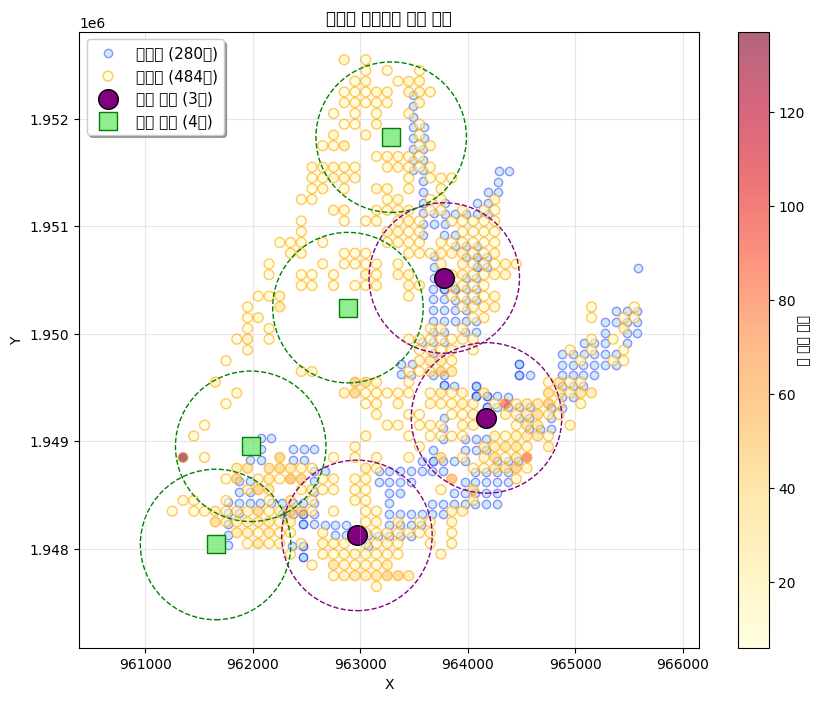

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

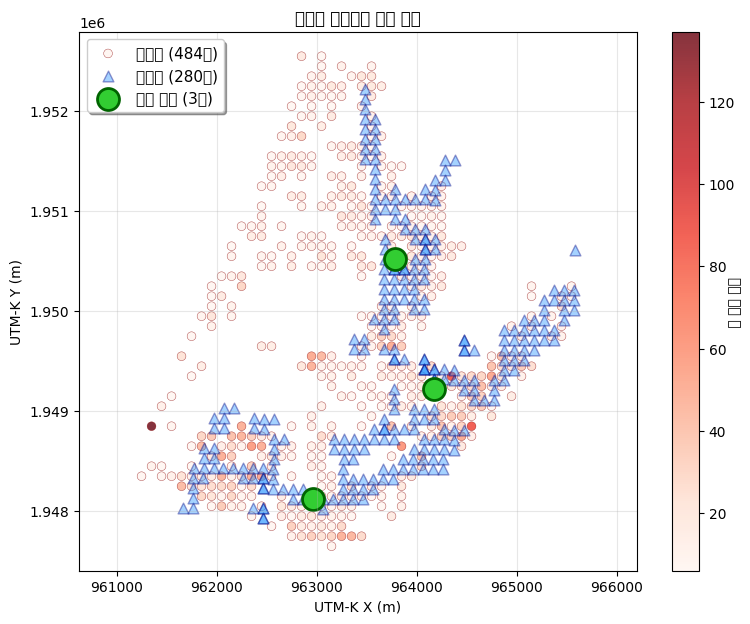

In [9]:

# 6. 시각화 실행
visual1(demandCoord, demandWeight, candidateCoord, existingCoords, selectedSites, 700, existingWeight, newWeight, totalWeight, totalPossible)
visual2(demandCoord, demandWeight, candidateCoord, existingCoords, selectedSites, 700, existingWeight, newWeight, totalWeight, totalPossible)


In [10]:
# 7. 통계 확인

print(f"전체 유아 인구: {totalPossible:.0f}명")
print(f"기존 시설 커버: {existingWeight:.0f}명 ({existingWeight/totalPossible*100:.1f}%)")
print(f"신규 추가 커버: {newWeight:.0f}명 ({newWeight/totalPossible*100:.1f}%)")
print(f"총 커버리지: {totalWeight:.0f}명 ({totalWeight/totalPossible*100:.1f}%)")
print(f"미커버: {totalPossible-totalWeight:.0f}명 ({(totalPossible-totalWeight)/totalPossible*100:.1f}%)")

전체 유아 인구: 7460명
기존 시설 커버: 2601명 (34.9%)
신규 추가 커버: 3620명 (48.5%)
총 커버리지: 6221명 (83.4%)
미커버: 1239명 (16.6%)


In [11]:
# 신규 시설 입지 좌표 출력

print("선정된 입지")
for idx, (x, y) in enumerate(selectedSites, 1):
    print(f"X={x:.2f}, Y={y:.2f}")

선정된 입지
X=963780.15, Y=1950519.49
X=964173.08, Y=1949217.88
X=962967.71, Y=1948124.69
